In [1]:
import warnings
import logging
import os

In [2]:
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback
from tensorflow.keras.losses import BinaryCrossentropy
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add, Dense, LayerNormalization,Masking, GlobalAveragePooling1D, Conv1D, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.callbacks import LearningRateScheduler, Callback, ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import Recall, Precision , AUC
from tensorflow.keras.layers.experimental.preprocessing import Normalization
#from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Model
import numpy as np
#from sklearn.metrics import auc, roc_curve
#import matplotlib.pyplot as plt


In [4]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

## Lr Scheduler

In [5]:

import math

def cosine_schedule(base_lr, total_steps, warmup_steps ):
    def step_fn(epoch):
        lr = base_lr 
        progress = (epoch - warmup_steps) / float(total_steps -  warmup_steps)

        progress = tf.clip_by_value(progress, 0.0, 1.0)

        lr = lr * 0.5 * (1.0 + tf.cos(math.pi * progress))
        
        if warmup_steps:
            lr = lr * tf.minimum(1.0 , epoch/warmup_steps)
        
        return lr
    

    return step_fn

## Positional Embedding

In [6]:

class PositionalEmbedding(Layer):
    def __init__(self, units,dropout_rate,  **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)

        self.units = units
        self.conv_1 = Conv1D(filters  = units, kernel_size = 1)
        self.projection = Dense(units, kernel_initializer=TruncatedNormal(stddev=0.02))

        self.dropout = Dropout(rate=dropout_rate)

    def build(self, input_shape):
        super(PositionalEmbedding, self).build(input_shape)

        self.position = self.add_weight(
            name="position",
            shape=(1, input_shape[1], self.units),
            initializer=TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, inputs, training):
        x = self.projection(inputs)
        # x = self.conv_1(inputs)
        x = x + self.position
        return self.dropout(x, training=training)

## Encoder

In [7]:
class Encoder(Layer):
    def __init__(
        self, embed_dim, mlp_dim, num_heads, dropout_rate,
        attention_dropout_rate, **kwargs
    ):
        super(Encoder, self).__init__(**kwargs)

        self.mha = MultiHeadAttention(
            num_heads = num_heads,
            key_dim = embed_dim,
            dropout = attention_dropout_rate, 
            kernel_initializer = TruncatedNormal(stddev = 0.02)
        )

        self. dense_0 = Dense(
            units = mlp_dim, 
            activation = "gelu", 
            kernel_initializer = TruncatedNormal(stddev = 0.02)
        )

        self.dense_1 = Dense(
            units = embed_dim, 
            kernel_initializer = TruncatedNormal(stddev = 0.02)
        )

        self.conv_0 = Conv1D(filters = 4 , kernel_size = 1, activation = 'relu')
        self.conv_1 = Conv1D(filters  = embed_dim, kernel_size = 1)

        self.dropout_0 = Dropout(rate = dropout_rate)
        self.dropout_1 = Dropout(rate = dropout_rate)

        self.norm_0 = LayerNormalization(epsilon = 1e-6)
        self.norm_1 = LayerNormalization(epsilon = 1e-6)

        self.add_0 = Add()
        self.add_1 = Add()
    
    def call(self, inputs, training , mask):


        x = self.norm_0(inputs)
        x = self.mha(
            query = x, 
            value = x, 
            key = x,
            attention_mask = mask,
            training = training
        ) #[batch_size, sequence_length, embed_dim][8, 500, 3]
        x = self.dropout_0(x, training= training)
        x = self.add_0([x, inputs])

        #MLP block 
        y = self.norm_1(x)
        y = self.dense_0(y) #[batch_size , sequence_length, neurons]
        y = self.dropout_1(y, training)
        y = self.dense_1(y)#[batch_size , sequence_lenght, neurons]
        y = self.dropout_1(y, training)
        

        return self.add_1([x, y])

## Transformer

In [8]:
class Transformer(Model):
    def __init__(
        self,
        num_layers,
        embed_dim,
        mlp_dim,
        num_heads,
        num_classes,
        dropout_rate,
        attention_dropout_rate,
        **kwargs
    ):
        super(Transformer, self).__init__(**kwargs)

        # Input (normalization of RAW measurements)
        self.input_norm = Normalization()
        
        #Making Layer
        self.masking_layer = Masking(mask_value = 0.0)

        # Input
        self.pos_embs = PositionalEmbedding(embed_dim, dropout_rate)

        # Encoder
        self.e_layers = [
            Encoder(embed_dim, mlp_dim, num_heads, dropout_rate, attention_dropout_rate)
            for _ in range(num_layers)
        ]

        # Output
        self.norm = LayerNormalization(epsilon=1e-5)
        self.pool = GlobalAveragePooling1D(data_format = 'channels_first')
        self.dense_0 = Dense(mlp_dim, activation = 'relu')
        self.final_layer = Dense(1, kernel_initializer="zeros", activation = 'sigmoid')

    def call(self, inputs, training = True):
        expanded_input = tf.cast(tf.tile(tf.expand_dims(inputs, axis=-2), [1, 1, 500,1]), tf.float32)
        self.masking_layer.build(expanded_input.shape)
        mask = self.masking_layer.compute_mask(expanded_input)
        x = self.input_norm(inputs) 
        x = self.pos_embs(x, training=training)
        for layer in self.e_layers:
            x = layer(x, training=training , mask = mask)
        x = self.norm(x)
        x = self.pool(x)
        x = self.dense_0(x)

        x = self.final_layer(x)
        return x

## Train Function 

In [9]:
    config = {
      'epochs': 50,
      'num_layers':  3,
      'embed_layer_size': 3,
      'global_clipnorm' : 3.0,
      'fc_layer_size': 256,
      'num_heads': 2,
      'dropout': 0.1,
      'attention_dropout': 0.1,
      'optimizer': 'adam',
      'amsgrad': False,
      'label_smoothing': 0.1,
      'learning_rate': 1e-3,
      #'weight_decay': {
      #    'values': [2.5e-4, 1e-4, 5e-5, 1e-5]
      'warmup_steps': 5,
      'batch_size': 8}
  

In [10]:
  def create_model():


    # config = wandb.config
    
    # Generate new model
    model = Transformer(
      num_layers=config['num_layers'],
      embed_dim=config['embed_layer_size']
      ,
      mlp_dim=config['fc_layer_size'],
      num_heads=config['num_heads'],
      num_classes=2,
      dropout_rate=config['dropout'],
      attention_dropout_rate=config['attention_dropout'],
    )

    

    # adapt on training dataset - must be before model.compile !!!
    model.input_norm.adapt(X_train)
    # print(model.input_norm.variables)

    # Select optimizer
    if config['optimizer'] == "adam":
      optim = Adam(
          global_clipnorm=config['global_clipnorm'],
          amsgrad=config['amsgrad'],
      )
    # elif config.optimizer == "adamw":
    #   optim = AdamW(
    #       weight_decay=config.weight_decay,
    #       amsgrad=config.amsgrad,
    #       global_clipnorm=config.global_clipnorm,
    #       exclude_from_weight_decay=["position"]
    #   )
    else:
      raise ValueError("The used optimizer is not in list of available")

    model.compile(
      loss= BinaryCrossentropy(label_smoothing=config['label_smoothing']),
      optimizer=optim,
      metrics=[Recall(), Precision() , AUC(), F1_Score()],
    )
    
    return model

In [11]:
def train():
    model = create_model()
    checkpoint_filepath = os.path.join(os.getcwd(), 'tmp/')
    model_checkpoint = ModelCheckpoint(filepath = checkpoint_filepath, 
                                      save_weights_only = False, 
                                      monitor = 'val_f1_score', 
                                      mode = 'max', 
                                      save_best_only = True, 
                                      verbose = True)

    # Train model
    history = model.fit(
      X_train,
      y_train,
      batch_size=config['batch_size'],
      epochs=config['epochs'],
      validation_data=(X_val, y_val),
      callbacks=[
        LearningRateScheduler(cosine_schedule(base_lr=config['learning_rate'], total_steps=config['epochs'], warmup_steps=config['warmup_steps'])),
        EarlyStopping(monitor="loss", mode='min', min_delta=0.001, patience=5),
        model_checkpoint
      ],
      verbose=1
    )
    return model

In [12]:
    model = None
    train_dataset_path = os.path.join(os.getcwd(), 'fall_detection_train.npz')
    test_dataset_path = os.path.join(os.getcwd(), 'fall_detection_test.npz')
    val_dataset_path = os.path.join(os.getcwd(), 'fall_detection_val.npz')
    
    #loading train dataset
    train_data = np.load(train_dataset_path)
    X_train = train_data['trials']
    y_train = train_data['labels']
    
    #loading val dataset 
    val_data = np.load(val_dataset_path)
    X_val = val_data['trials']
    y_val = val_data['labels']

    #loading test dataset
    test_data = np.load(test_dataset_path)


#     # split to train-test
#     X_train, X_test, y_train, y_test = train_test_split(
#         signals, labels, test_size=0.15, random_state=9, stratify=labels
#     )
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_train, y_train, test_size=0.15, random_state=9, stratify=y_train
#     )

    # sweep_id = wandb.sweep(sweep_config, project="KD_Transformer")
    with tf.device('/gpu:0'):
      model = train()

Epoch 1/50
87/87 [==============================] - 13s 76ms/step - loss: 0.6931 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc: 0.5000 - f1_score: 0.0000e+00 - val_loss: 0.6931 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_auc: 0.5000 - val_f1_score: 0.0000e+00

Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to /home/bgu9/KD_Multimodal/tmp/
Epoch 2/50
87/87 [==============================] - 5s 53ms/step - loss: 0.6931 - recall: 0.8801 - precision: 0.5181 - auc: 0.5000 - f1_score: 0.6470 - val_loss: 0.6930 - val_recall: 1.0000 - val_precision: 0.4545 - val_auc: 0.5000 - val_f1_score: 0.6250

Epoch 00002: val_f1_score improved from 0.00000 to 0.62500, saving model to /home/bgu9/KD_Multimodal/tmp/
Epoch 3/50
87/87 [==============================] - 4s 52ms/step - loss: 0.6783 - recall: 0.9925 - precision: 0.5665 - auc: 0.6351 - f1_score: 0.7200 - val_loss: 0.5725 - val_recall: 0.7000 - val_precision: 0.7143 - val_auc: 0.8050 - val_f1_score: 0.7071

In [26]:
# test data
X_test = test_data['trials']
y_test = test_data['labels']

### Loading the Best Weights

In [30]:
model = create_model()

#Just to build the model first, we called this evaluate
model.evaluate(X_test, y_test, batch_size=8, steps=X_test.shape[0]/8)

#loading best weights and evaluating
weight_path = 'tmp/weights.ckpt'
model.load_weights(weight_path)
history = model.evaluate(X_test, y_test, batch_size=8, steps=X_test.shape[0]/8)

## Ploting ROC Curve

In [25]:
y_pred = model.predict(X_test).ravel()
fp_pred, tp_pred, threshold_pred = roc_curve(y_test, y_pred)

3/3 [==============================] - 2s 387ms/step


In [26]:
auc = auc(fp_pred, tp_pred)

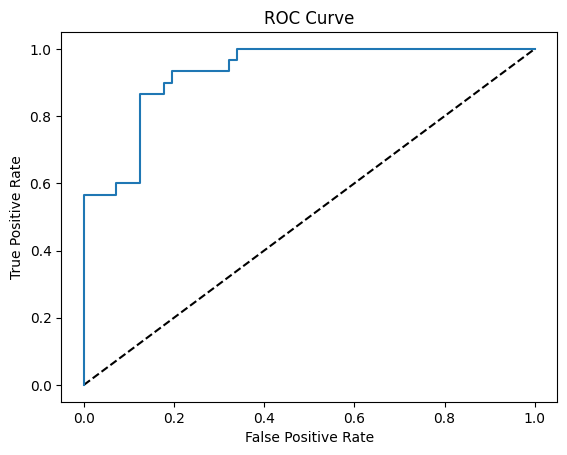

In [27]:
plt.figure()
plt.plot([0,1], [0, 1], 'k--')
plt.plot(fp_pred, tp_pred, label = 'SmartFall (area = {:.3f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()